In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from qbstyles import mpl_style

from drawdata import ScatterWidget

mpl_style()

In [135]:
def model_line(model, X, y, color_dp3d="black", color_dp2d="red", color_line2d="white", color_line3d="white", alpha=0.5):
    if X.shape[1] == 1:  # 2D Case
        plt.scatter(X.iloc[:, 0], y, marker=".", color=color_dp2d, label="Data")
        y_pred = model.predict(X).flatten()
        plt.plot(X.iloc[:, 0], y_pred, color=color_line2d, label="Model Prediction")
        plt.xlabel(X.columns[0])
        plt.ylabel(y.name)
        plt.legend()

    elif X.shape[1] == 2:  # 3D Case
        plt.ion()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], y, color=color_dp3d, label="Data", marker=".")

        X_vals = X.iloc[:, 0]
        Y_vals = X.iloc[:, 1]
        Z_vals = model.predict(X).flatten()
        ax.plot_trisurf(X_vals, Y_vals, Z_vals, color=color_line3d, alpha=alpha)

        ax.set_xlabel(X.columns[0])
        ax.set_ylabel(X.columns[1])
        ax.set_zlabel(y.name)
        plt.legend()
        plt.show()

    else:
        raise ValueError("Only 1D or 2D features are supported.")


def predictor_line(model, X, y, dot_color="yellow", line_color="cyan", marker="."):
    pred = model.predict(X).flatten()
    y_true = y.to_numpy().flatten()
    start = min(y_true.min(), pred.min())
    end = max(y_true.max(), pred.max())
    line = np.linspace(start, end, 100)

    plt.scatter(y_true, pred, marker=marker, color=dot_color)
    plt.plot(line, line, color=line_color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()


def model_equation(model, feature_names, target_label, variable_as_name=False):
    # Check if model is Keras (has get_weights)
    if hasattr(model, "get_weights"):
        weights = model.get_weights()
        coef = weights[0].flatten()
        intercept = weights[1].item()
    # Else assume it's sklearn
    elif hasattr(model, "coef_") and hasattr(model, "intercept_"):
        coef = model.coef_.flatten()
        intercept = model.intercept_.item() if hasattr(model.intercept_, 'item') else model.intercept_
    else:
        raise ValueError("Unsupported model type")

    # Variable name handling
    if variable_as_name:
        variables = [f"{name}" for name in feature_names]
        y = target_label
    else:
        variables = [f"x{i}" for i in range(1, len(feature_names) + 1)]
        y = "y"
        for variable, feature_name in zip(variables, feature_names):
            print(f"{variable} = {feature_name}")
        print(f"{y} = {target_label}")

    # Construct equation
    terms = [f"{coef[i]:.2f} * {variables[i]}" for i in range(len(coef))]
    equation = f"{y} = {terms[0]}"
    for term in terms[1:]:
        if term.startswith('-'):
            equation += f" - {term[1:]}"
        else:
            equation += f" + {term}"
    equation += f" + {intercept:.2f}" if intercept >= 0 else f" - {-intercept:.2f}"
    return equation


def loss_curve(history, color="blue"):
    plt.plot(history.history['loss'], color=color, label='Training Loss')
    plt.title('Model Loss Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [3]:
widget = ScatterWidget()

In [5]:
widget

ScatterWidget()

In [6]:
df = widget.data_as_pandas

In [7]:
df

,x,y,color,label
0,35.420828,492.475846,#1f77b4,a
1,23.495553,482.073664,#1f77b4,a
2,50.618555,502.536058,#1f77b4,a
3,51.316430,492.656347,#1f77b4,a
4,39.549788,467.207244,#1f77b4,a
...,...,...,...,...
283,751.689212,428.317786,#1f77b4,a
284,750.512478,424.408148,#1f77b4,a
285,741.570066,415.022659,#1f77b4,a
286,735.246283,447.695151,#1f77b4,a


<Axes: xlabel='x', ylabel='y'>

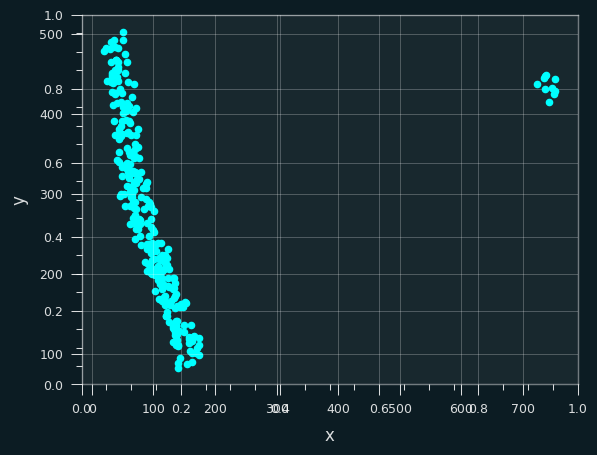

In [8]:
df.plot.scatter('x', 'y', color="cyan")

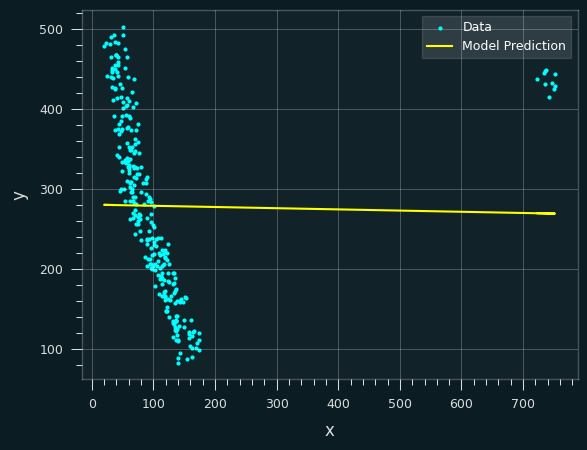

In [9]:
X = df[['x']]
y = df['y']

sklearn_model = LinearRegression()
sklearn_model.fit(X, y)

model_line(sklearn_model, X, y, color_dp2d="cyan", color_line2d="yellow")

In [52]:
X = df[["x"]]
y = df["y"]

keras_model_mse = Sequential([
    Input(shape=(1,)),
    Dense(units=1, activation="linear")
], name="keras_model_mse")

keras_model_mse.compile(loss="mse", optimizer=Adam(learning_rate=0.655))
keras_model_mse.summary()

Model: "keras_model_mse"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = keras_model_mse.fit(
    X, y, 
    batch_size=64,
    epochs=60,
    verbose=0,
)

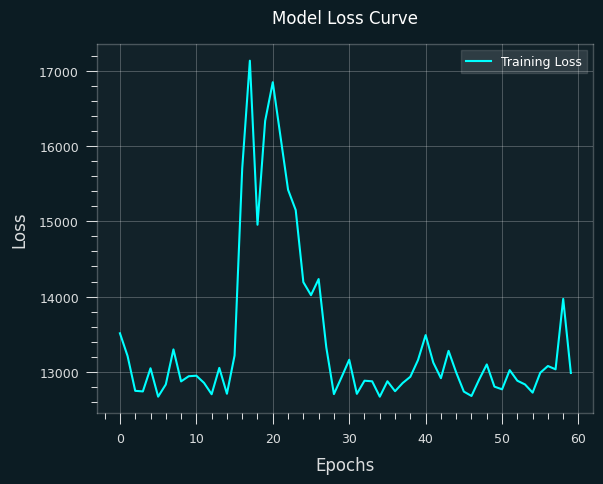

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
MSE of sklearn: 12,656.56
MSE of keras: 12,828.84


In [64]:
loss_curve(history, "cyan")

sklearn_mse = mean_squared_error(y, sklearn_model.predict(X))
keras_mse = mean_squared_error(y, keras_model_mse.predict(X))

print(f"MSE of sklearn: {sklearn_mse:,.2f}")
print(f"MSE of keras: {keras_mse:,.2f}")

In [106]:
X = df[["x"]]
y = df["y"]

keras_model_mae = Sequential([
    Input(shape=(1,)),
    Dense(units=1, activation="linear"),
], name="keras_model_mae")

keras_model_mae.compile(loss="mae", optimizer=Adam(learning_rate=0.8))
keras_model_mae.summary()

Model: "keras_model_mae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

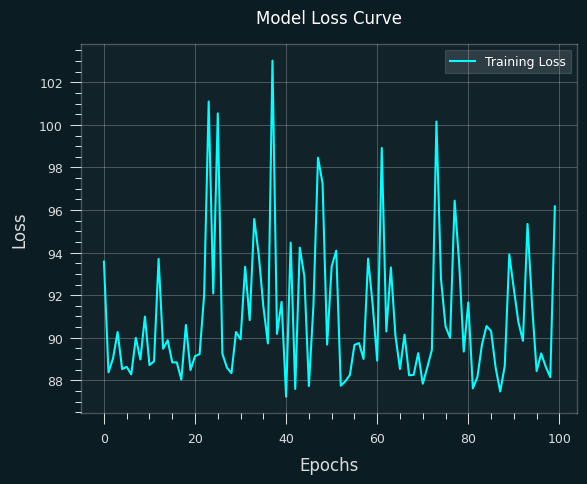

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MAE of keras: 93.86
Accuracy of keras_model_mae: -434.24


In [119]:
history = keras_model_mae.fit(
    X, y,
    batch_size=32,
    epochs=100,
    verbose=0,
)

loss_curve(history, "cyan")
keras_mae = mean_absolute_error(y, keras_model_mae.predict(X))
accuracy = r2_score(y, keras_model_mae.predict(X)) * 100
print(f"MAE of keras: {keras_mae:,.2f}")
print(f"Accuracy of keras_model_mae: {accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


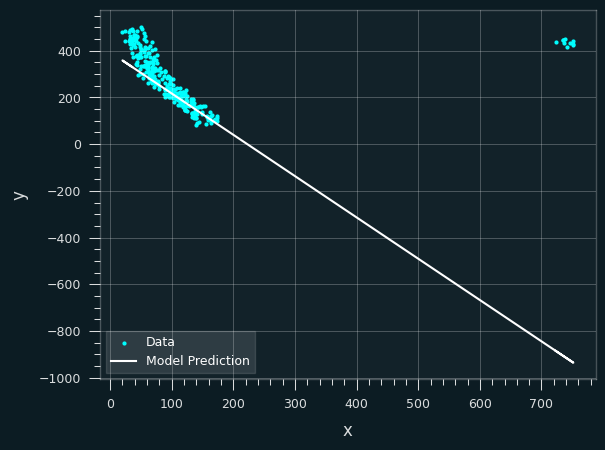

In [120]:
model_line(keras_model_mae, X, y, color_dp2d="cyan")

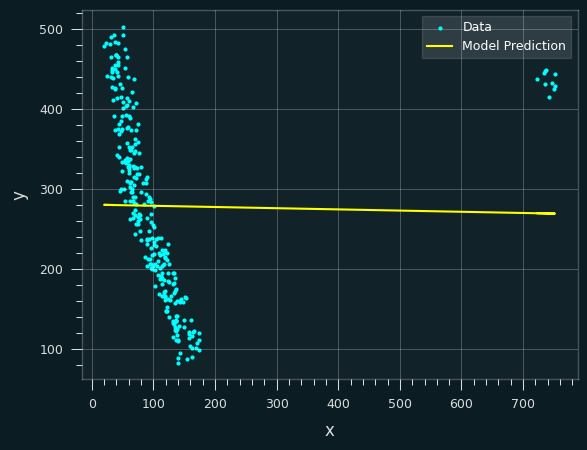

In [121]:
model_line(sklearn_model, X, y, color_dp2d="cyan", color_line2d="yellow")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


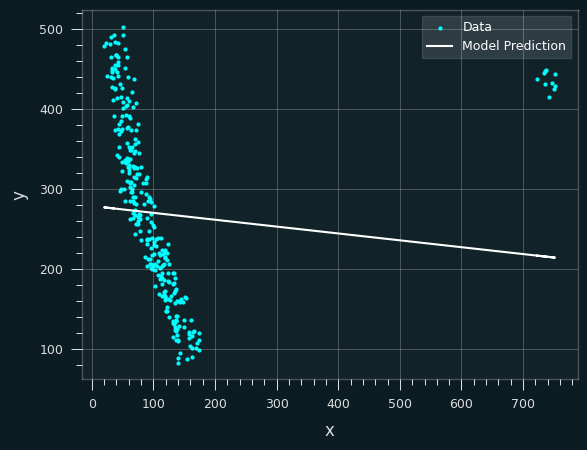

In [122]:
model_line(keras_model_mse, X, y, color_dp2d="cyan")

In [137]:
accuracy_mse = r2_score(y, keras_model_mse.predict(X)) * 100
accuracy_mae = r2_score(y, keras_model_mae.predict(X)) * 100
accuracy_skl = r2_score(y, sklearn_model.predict(X)) * 100

print(f"{accuracy_mse = :.2f}")
print(f"{accuracy_mae = :.2f}")
print(f"{accuracy_skl = :.2f}")
print()

equation_mse = model_equation(keras_model_mse, ['x'], "y")
equation_mae = model_equation(keras_model_mae, ["x"], "y")
equation_skl = model_equation(sklearn_model, ["x"], "y")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
accuracy_mse = -1.33
accuracy_mae = -434.24
accuracy_skl = 0.03

x1 = x
y = y
x1 = x
y = y
x1 = x
y = y


In [138]:
print(f"{equation_mae = }")
print(f"{equation_mse = }")
print(f"{equation_skl = }")

equation_mae = 'y = -1.77 * x1 + 393.32'
equation_mse = 'y = -0.09 * x1 + 278.51'
equation_skl = 'y = -0.01 * x1 + 280.24'
